In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [2]:
with open(r"data/NER_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/NER_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/NER_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
model = fasttext.load_model("cc.en.300.bin")

In [4]:
word_embedding = model.get_word_vector('hello')
print(word_embedding)

[ 1.57576188e-01  4.37820926e-02 -4.51271934e-03  6.65931404e-02
  7.70346820e-02  4.85855248e-03  8.19822028e-03  6.52402919e-03
  9.25899856e-03  3.53899002e-02 -2.31395271e-02 -4.91807126e-02
 -8.32642540e-02  1.56014524e-02  2.54856616e-01  3.45423706e-02
 -1.07451361e-02 -7.80188590e-02 -7.08099529e-02  7.62385577e-02
 -6.09613657e-02  4.48625796e-02 -7.29744136e-02  1.30583309e-02
  3.14881057e-02 -3.10055036e-02  1.66004002e-02  1.74405202e-02
 -7.35838860e-02  1.18252613e-01 -1.21330231e-01 -4.09253240e-02
  2.93969568e-02  4.84445989e-02 -1.33816330e-02 -1.74765270e-02
  7.51308873e-02  9.97046307e-02 -4.00476977e-02  4.05735290e-03
 -7.21896589e-02 -4.43356819e-02 -1.22628408e-03  7.56693557e-02
  3.98401320e-02  3.22643593e-02  1.95914153e-02  4.68016043e-02
 -1.46228177e-02  1.12967767e-01  3.15065160e-02 -1.02312110e-01
  1.58124104e-01 -2.76147053e-02 -3.39851156e-02 -1.77006852e-02
 -5.73529862e-04  1.10789239e-01 -1.64533369e-02 -3.14955460e-03
 -4.22914140e-02  1.11429

In [5]:
def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
                embedding.append(model.get_word_vector(word))
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 70 # maximum length of word in 1 text 
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(model.get_word_vector("Hello"))] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [6]:

x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_45967/937020881.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings)


In [7]:
x_train.size()

torch.Size([8019, 70, 300])

In [8]:
# unique_labels = set()
# for example in train_data.values():
#     unique_labels.update(example['labels'])
# for example in test_data.values():
#     unique_labels.update(example['labels'])
# for example in val_data.values():
#     unique_labels.update(example['labels'])
# unique_labels.remove('O')
# label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
# label_to_index['O'] = max(label_to_index.values()) +1
# print((label_to_index))

In [9]:
def convert_labels_to_fixed_length(labels, max_length):
    label_to_index = {'I_WITNESS': 0, 'B_JUDGE': 1, 'I_CASE_NUMBER': 2, 'B_CASE_NUMBER': 3, 'I_PROVISION': 4, 'B_STATUTE': 5, 'I_DATE': 6, 'I_STATUTE': 7, 'B_WITNESS': 8, 'B_DATE': 9, 'I_RESPONDENT': 10, 'B_PRECEDENT': 11, 'B_GPE': 12, 'I_ORG': 13, 'I_PETITIONER': 14, 'B_PROVISION': 15, 'B_ORG': 16, 'I_JUDGE': 17, 'I_OTHER_PERSON': 18, 'B_COURT': 19, 'B_PETITIONER': 20, 'B_RESPONDENT': 21, 'I_PRECEDENT': 22, 'I_COURT': 23, 'I_GPE': 24, 'B_OTHER_PERSON': 25, 'O': 26, '<pad>':27}
    new_list=[]
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 27
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 70
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [10]:
y_train.size()

torch.Size([8019, 70])

In [11]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


/home/bsumit43/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class GRUTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUTagger, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 28
learning_rate = 0.001
num_epochs = 130
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = GRUTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_45967/3909336609.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_45967/3909336609.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_45967/3909336609.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_45967/3909336609.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/130, Train Loss: 1.4512247197211734, Val Loss: 0.8892521858215332, Val F1: 0.03910298808412845, Train F1: 0.034690230907830834


  2%|▋                                          | 2/130 [00:11<11:52,  5.57s/it]

Epoch 2/130, Train Loss: 0.8235154492514474, Val Loss: 0.751627504825592, Val F1: 0.054963610492582346, Train F1: 0.050195030017504284


  2%|▉                                          | 3/130 [00:16<11:44,  5.54s/it]

Epoch 3/130, Train Loss: 0.7175815077055068, Val Loss: 0.6693263053894043, Val F1: 0.05784317289192182, Train F1: 0.05597386697425099


  3%|█▎                                         | 4/130 [00:22<11:37,  5.53s/it]

Epoch 4/130, Train Loss: 0.6434366513812353, Val Loss: 0.5994675755500793, Val F1: 0.09231393721631329, Train F1: 0.06856158274467748


  4%|█▋                                         | 5/130 [00:27<11:33,  5.55s/it]

Epoch 5/130, Train Loss: 0.5780122951855735, Val Loss: 0.5385771989822388, Val F1: 0.14158038134748857, Train F1: 0.11273789881436885


  5%|█▉                                         | 6/130 [00:33<11:28,  5.56s/it]

Epoch 6/130, Train Loss: 0.525569566658565, Val Loss: 0.4969481825828552, Val F1: 0.19214836501175633, Train F1: 0.16478490660326137


  5%|██▎                                        | 7/130 [00:38<11:23,  5.56s/it]

Epoch 7/130, Train Loss: 0.4926696750852797, Val Loss: 0.47103333473205566, Val F1: 0.22385765795231094, Train F1: 0.2078794993561125


  6%|██▋                                        | 8/130 [00:44<11:16,  5.54s/it]

Epoch 8/130, Train Loss: 0.46919151431038264, Val Loss: 0.45513179898262024, Val F1: 0.24454956741987963, Train F1: 0.23467545223095995


  7%|██▉                                        | 9/130 [00:49<11:12,  5.56s/it]

Epoch 9/130, Train Loss: 0.4532339222847469, Val Loss: 0.4406304955482483, Val F1: 0.2565937219577037, Train F1: 0.2506903698710316


  8%|███▏                                      | 10/130 [00:55<11:05,  5.55s/it]

Epoch 10/130, Train Loss: 0.4386556228948018, Val Loss: 0.42844703793525696, Val F1: 0.27179725809639843, Train F1: 0.2599823815411156


  8%|███▌                                      | 11/130 [01:01<10:59,  5.54s/it]

Epoch 11/130, Train Loss: 0.4266177098902445, Val Loss: 0.41903433203697205, Val F1: 0.28716645502207444, Train F1: 0.2676108413005592


  9%|███▉                                      | 12/130 [01:06<10:53,  5.54s/it]

Epoch 12/130, Train Loss: 0.41640828431598725, Val Loss: 0.4111268222332001, Val F1: 0.2839560259971173, Train F1: 0.27817374131683986


 10%|████▏                                     | 13/130 [01:12<10:47,  5.53s/it]

Epoch 13/130, Train Loss: 0.4082350494369628, Val Loss: 0.4057545065879822, Val F1: 0.27490997520201155, Train F1: 0.28656412169962925


 11%|████▌                                     | 14/130 [01:17<10:40,  5.52s/it]

Epoch 14/130, Train Loss: 0.3996091305263459, Val Loss: 0.39822256565093994, Val F1: 0.2932920323985501, Train F1: 0.2953065314401901


 12%|████▊                                     | 15/130 [01:23<10:36,  5.53s/it]

Epoch 15/130, Train Loss: 0.3915808896223704, Val Loss: 0.3929736316204071, Val F1: 0.29319118496207563, Train F1: 0.3022996674149069


 12%|█████▏                                    | 16/130 [01:28<10:30,  5.53s/it]

Epoch 16/130, Train Loss: 0.38516806515436325, Val Loss: 0.38841143250465393, Val F1: 0.3134256588654381, Train F1: 0.3091281278923174


 13%|█████▍                                    | 17/130 [01:34<10:24,  5.52s/it]

Epoch 17/130, Train Loss: 0.379323169825569, Val Loss: 0.38548505306243896, Val F1: 0.3052753202803573, Train F1: 0.314581883833631


 14%|█████▊                                    | 18/130 [01:39<10:18,  5.52s/it]

Epoch 18/130, Train Loss: 0.3740168161808498, Val Loss: 0.3807411193847656, Val F1: 0.3134707179307899, Train F1: 0.3221310739008095


 15%|██████▏                                   | 19/130 [01:45<10:12,  5.52s/it]

Epoch 19/130, Train Loss: 0.36749263509871466, Val Loss: 0.3796701729297638, Val F1: 0.3271793181337984, Train F1: 0.3350839727311026


 15%|██████▍                                   | 20/130 [01:50<10:08,  5.53s/it]

Epoch 20/130, Train Loss: 0.3625778234194195, Val Loss: 0.37744012475013733, Val F1: 0.3163438119320364, Train F1: 0.34008598088469905


 16%|██████▊                                   | 21/130 [01:56<10:05,  5.55s/it]

Epoch 21/130, Train Loss: 0.3571475592870561, Val Loss: 0.3721940517425537, Val F1: 0.33969491368103727, Train F1: 0.34630747491860114


 17%|███████                                   | 22/130 [02:01<10:01,  5.57s/it]

Epoch 22/130, Train Loss: 0.3535738932707953, Val Loss: 0.3703962564468384, Val F1: 0.34580569237198167, Train F1: 0.35584660546738084


 18%|███████▍                                  | 23/130 [02:07<09:54,  5.55s/it]

Epoch 23/130, Train Loss: 0.3503967197168441, Val Loss: 0.369380384683609, Val F1: 0.3466888934740421, Train F1: 0.36195845977302793


 18%|███████▊                                  | 24/130 [02:13<09:47,  5.55s/it]

Epoch 24/130, Train Loss: 0.3448750282090808, Val Loss: 0.3655678331851959, Val F1: 0.3461286962883571, Train F1: 0.36848198993089076


 19%|████████                                  | 25/130 [02:18<09:41,  5.54s/it]

Epoch 25/130, Train Loss: 0.3409226546211848, Val Loss: 0.36591896414756775, Val F1: 0.35516846795922835, Train F1: 0.3711682793262112


 20%|████████▍                                 | 26/130 [02:24<09:35,  5.53s/it]

Epoch 26/130, Train Loss: 0.3367846802113548, Val Loss: 0.3656446635723114, Val F1: 0.34893530056699784, Train F1: 0.3839661359317108


 21%|████████▋                                 | 27/130 [02:29<09:28,  5.52s/it]

Epoch 27/130, Train Loss: 0.3332001670958504, Val Loss: 0.3644147217273712, Val F1: 0.35647363874651616, Train F1: 0.38935946844631647


 22%|█████████                                 | 28/130 [02:35<09:22,  5.52s/it]

Epoch 28/130, Train Loss: 0.32818951918965295, Val Loss: 0.3643909990787506, Val F1: 0.34947550014018625, Train F1: 0.3895507436153944


 22%|█████████▎                                | 29/130 [02:40<09:15,  5.50s/it]

Epoch 29/130, Train Loss: 0.3247524022109925, Val Loss: 0.3620065748691559, Val F1: 0.3600697033193638, Train F1: 0.3981156015137592


 23%|█████████▋                                | 30/130 [02:45<09:08,  5.49s/it]

Epoch 30/130, Train Loss: 0.3209249552280184, Val Loss: 0.3640630543231964, Val F1: 0.3529612686516085, Train F1: 0.40041806770999816


 24%|██████████                                | 31/130 [02:51<09:04,  5.50s/it]

Epoch 31/130, Train Loss: 0.317485887143347, Val Loss: 0.3650805354118347, Val F1: 0.3554339583263136, Train F1: 0.4077520084214719


 25%|██████████▎                               | 32/130 [02:56<08:58,  5.49s/it]

Epoch 32/130, Train Loss: 0.31510572679459103, Val Loss: 0.36217185854911804, Val F1: 0.36387994842797006, Train F1: 0.41309197754571697


 25%|██████████▋                               | 33/130 [03:02<08:51,  5.48s/it]

Epoch 33/130, Train Loss: 0.31061318256552256, Val Loss: 0.3610437214374542, Val F1: 0.3685904204248244, Train F1: 0.42253615816332063


 26%|██████████▉                               | 34/130 [03:07<08:46,  5.48s/it]

Epoch 34/130, Train Loss: 0.30749123508021947, Val Loss: 0.36084866523742676, Val F1: 0.3730966031459307, Train F1: 0.4206880038452181


 27%|███████████▎                              | 35/130 [03:13<08:41,  5.49s/it]

Epoch 35/130, Train Loss: 0.3050446363668593, Val Loss: 0.36817294359207153, Val F1: 0.3754299164906822, Train F1: 0.4273411996987419


 28%|███████████▋                              | 36/130 [03:18<08:35,  5.48s/it]

Epoch 36/130, Train Loss: 0.30293899348803927, Val Loss: 0.3611014783382416, Val F1: 0.3810606529048919, Train F1: 0.4307663995089461


 28%|███████████▉                              | 37/130 [03:24<08:31,  5.50s/it]

Epoch 37/130, Train Loss: 0.29779588111809324, Val Loss: 0.36659136414527893, Val F1: 0.37102295282623127, Train F1: 0.44112132258148196


 29%|████████████▎                             | 38/130 [03:29<08:25,  5.50s/it]

Epoch 38/130, Train Loss: 0.2955295651678055, Val Loss: 0.36246901750564575, Val F1: 0.398722302372771, Train F1: 0.44135259502828866


 30%|████████████▌                             | 39/130 [03:35<08:21,  5.51s/it]

Epoch 39/130, Train Loss: 0.29313235576190644, Val Loss: 0.36618733406066895, Val F1: 0.40121508817997686, Train F1: 0.44775464632732037


 31%|████████████▉                             | 40/130 [03:41<08:17,  5.53s/it]

Epoch 40/130, Train Loss: 0.2892896360348141, Val Loss: 0.3633534014225006, Val F1: 0.39945186464387844, Train F1: 0.45348525916264176


 32%|█████████████▏                            | 41/130 [03:46<08:11,  5.53s/it]

Epoch 41/130, Train Loss: 0.2855669068438666, Val Loss: 0.3690108060836792, Val F1: 0.3881026681444936, Train F1: 0.45899209286162057


 32%|█████████████▌                            | 42/130 [03:52<08:08,  5.55s/it]

Epoch 42/130, Train Loss: 0.2835338900959681, Val Loss: 0.3664683997631073, Val F1: 0.3923498405866436, Train F1: 0.45877619019995913


 33%|█████████████▉                            | 43/130 [03:57<08:01,  5.54s/it]

Epoch 43/130, Train Loss: 0.2802747365028139, Val Loss: 0.3676498234272003, Val F1: 0.39731759938887107, Train F1: 0.4667233405466371


 34%|██████████████▏                           | 44/130 [04:03<07:55,  5.52s/it]

Epoch 44/130, Train Loss: 0.2778020595747327, Val Loss: 0.3711923062801361, Val F1: 0.40137789604443264, Train F1: 0.47401453928272075


 35%|██████████████▌                           | 45/130 [04:08<07:48,  5.51s/it]

Epoch 45/130, Train Loss: 0.27420989364858656, Val Loss: 0.37646743655204773, Val F1: 0.39574989825837564, Train F1: 0.47483548015894256


 35%|██████████████▊                           | 46/130 [04:14<07:42,  5.51s/it]

Epoch 46/130, Train Loss: 0.2720939079447398, Val Loss: 0.36996546387672424, Val F1: 0.40638219812962106, Train F1: 0.4809007851527656


 36%|███████████████▏                          | 47/130 [04:19<07:37,  5.51s/it]

Epoch 47/130, Train Loss: 0.26942648206438335, Val Loss: 0.38043272495269775, Val F1: 0.39488451286426385, Train F1: 0.48418006351223514


 37%|███████████████▌                          | 48/130 [04:25<07:32,  5.51s/it]

Epoch 48/130, Train Loss: 0.26700827077267664, Val Loss: 0.3752449154853821, Val F1: 0.40815607325883285, Train F1: 0.4859729461244304


 38%|███████████████▊                          | 49/130 [04:30<07:26,  5.52s/it]

Epoch 49/130, Train Loss: 0.2638389704719422, Val Loss: 0.37552356719970703, Val F1: 0.4041949671210193, Train F1: 0.4934128323614773


 38%|████████████████▏                         | 50/130 [04:36<07:20,  5.51s/it]

Epoch 50/130, Train Loss: 0.2618876738207681, Val Loss: 0.3783188462257385, Val F1: 0.42197882441575635, Train F1: 0.4950918830523684


 39%|████████████████▍                         | 51/130 [04:41<07:15,  5.51s/it]

Epoch 51/130, Train Loss: 0.25901653511183603, Val Loss: 0.3808746635913849, Val F1: 0.41372457363477444, Train F1: 0.501592357204319


 40%|████████████████▊                         | 52/130 [04:47<07:16,  5.59s/it]

Epoch 52/130, Train Loss: 0.2570092131694158, Val Loss: 0.3800866901874542, Val F1: 0.41350753057476436, Train F1: 0.5085754650992925


 41%|█████████████████                         | 53/130 [04:53<07:14,  5.65s/it]

Epoch 53/130, Train Loss: 0.25393630753433893, Val Loss: 0.38330933451652527, Val F1: 0.41895768354536544, Train F1: 0.5093438307109398


 42%|█████████████████▍                        | 54/130 [04:58<07:06,  5.62s/it]

Epoch 54/130, Train Loss: 0.25092068030720666, Val Loss: 0.38720542192459106, Val F1: 0.40438163818425577, Train F1: 0.5180220316725758


 42%|█████████████████▊                        | 55/130 [05:04<06:59,  5.59s/it]

Epoch 55/130, Train Loss: 0.2503422841666237, Val Loss: 0.38868287205696106, Val F1: 0.4258631315975388, Train F1: 0.5157956479747983


 43%|██████████████████                        | 56/130 [05:09<06:51,  5.57s/it]

Epoch 56/130, Train Loss: 0.24597862599388, Val Loss: 0.3920632004737854, Val F1: 0.41288215550565643, Train F1: 0.5251471683423795


 44%|██████████████████▍                       | 57/130 [05:15<06:45,  5.55s/it]

Epoch 57/130, Train Loss: 0.24375159423502665, Val Loss: 0.3973195552825928, Val F1: 0.4155338683502574, Train F1: 0.5252335321296672


 45%|██████████████████▋                       | 58/130 [05:20<06:38,  5.54s/it]

Epoch 58/130, Train Loss: 0.24243229154556517, Val Loss: 0.3925856351852417, Val F1: 0.42009095069724506, Train F1: 0.5257443938913731


 45%|███████████████████                       | 59/130 [05:26<06:33,  5.55s/it]

Epoch 59/130, Train Loss: 0.2380031654759059, Val Loss: 0.4085724353790283, Val F1: 0.40046954086104314, Train F1: 0.5396535997966607


 46%|███████████████████▍                      | 60/130 [05:31<06:27,  5.54s/it]

Epoch 60/130, Train Loss: 0.23513845886502946, Val Loss: 0.4029286205768585, Val F1: 0.4151082526136598, Train F1: 0.5414841911849032


 47%|███████████████████▋                      | 61/130 [05:37<06:21,  5.54s/it]

Epoch 61/130, Train Loss: 0.23406084449518294, Val Loss: 0.4017764627933502, Val F1: 0.42272543522130834, Train F1: 0.5458252075822633


 48%|████████████████████                      | 62/130 [05:43<06:17,  5.55s/it]

Epoch 62/130, Train Loss: 0.23248181480263908, Val Loss: 0.40611550211906433, Val F1: 0.40880274657040067, Train F1: 0.551912891247679


 48%|████████████████████▎                     | 63/130 [05:48<06:10,  5.53s/it]

Epoch 63/130, Train Loss: 0.22894722719987234, Val Loss: 0.41447052359580994, Val F1: 0.4134693351679297, Train F1: 0.5546195569623577


 49%|████████████████████▋                     | 64/130 [05:54<06:06,  5.55s/it]

Epoch 64/130, Train Loss: 0.22642894609579964, Val Loss: 0.4225040376186371, Val F1: 0.412065024451001, Train F1: 0.5566236849051992


 50%|█████████████████████                     | 65/130 [05:59<06:01,  5.56s/it]

Epoch 65/130, Train Loss: 0.22390287617842355, Val Loss: 0.41739627718925476, Val F1: 0.42738678048738665, Train F1: 0.5627389696898422


 51%|█████████████████████▎                    | 66/130 [06:05<05:55,  5.55s/it]

Epoch 66/130, Train Loss: 0.22166838816234044, Val Loss: 0.41870352625846863, Val F1: 0.4206189405034594, Train F1: 0.5683610129135319


 52%|█████████████████████▋                    | 67/130 [06:10<05:48,  5.54s/it]

Epoch 67/130, Train Loss: 0.2192011189366144, Val Loss: 0.43118560314178467, Val F1: 0.4120004507657594, Train F1: 0.5733891465107722


 52%|█████████████████████▉                    | 68/130 [06:16<05:43,  5.54s/it]

Epoch 68/130, Train Loss: 0.21696467366483477, Val Loss: 0.4243704676628113, Val F1: 0.40461177071997023, Train F1: 0.577414328539123


 53%|██████████████████████▎                   | 69/130 [06:21<05:37,  5.53s/it]

Epoch 69/130, Train Loss: 0.2134436915318171, Val Loss: 0.4306761920452118, Val F1: 0.41145442843475, Train F1: 0.5799137801232694


 54%|██████████████████████▌                   | 70/130 [06:27<05:31,  5.53s/it]

Epoch 70/130, Train Loss: 0.2130978549756701, Val Loss: 0.43069133162498474, Val F1: 0.41978658668936547, Train F1: 0.5826092713672777


 55%|██████████████████████▉                   | 71/130 [06:32<05:25,  5.52s/it]

Epoch 71/130, Train Loss: 0.20995387198433044, Val Loss: 0.43694695830345154, Val F1: 0.42156643471899535, Train F1: 0.5895565084643952


 55%|███████████████████████▎                  | 72/130 [06:38<05:20,  5.52s/it]

Epoch 72/130, Train Loss: 0.20720217956437004, Val Loss: 0.44331982731819153, Val F1: 0.41755233724108126, Train F1: 0.5950911941991178


 56%|███████████████████████▌                  | 73/130 [06:43<05:14,  5.52s/it]

Epoch 73/130, Train Loss: 0.20580318049779014, Val Loss: 0.43829312920570374, Val F1: 0.4145372010953459, Train F1: 0.5959759786040404


 57%|███████████████████████▉                  | 74/130 [06:49<05:09,  5.52s/it]

Epoch 74/130, Train Loss: 0.2031627046683478, Val Loss: 0.4474431872367859, Val F1: 0.410536022447111, Train F1: 0.6012177020462819


 58%|████████████████████████▏                 | 75/130 [06:55<05:04,  5.54s/it]

Epoch 75/130, Train Loss: 0.20059151947498322, Val Loss: 0.4569877088069916, Val F1: 0.40825809558764453, Train F1: 0.6059180129510743


 58%|████████████████████████▌                 | 76/130 [07:00<04:58,  5.53s/it]

Epoch 76/130, Train Loss: 0.19842844042513105, Val Loss: 0.45200836658477783, Val F1: 0.4127591106359052, Train F1: 0.6160950108811951


 59%|████████████████████████▉                 | 77/130 [07:06<04:52,  5.52s/it]

Epoch 77/130, Train Loss: 0.19553453912810673, Val Loss: 0.4592794179916382, Val F1: 0.40888817829664803, Train F1: 0.6166991757912145


 60%|█████████████████████████▏                | 78/130 [07:11<04:46,  5.52s/it]

Epoch 78/130, Train Loss: 0.19275854007592277, Val Loss: 0.4717866778373718, Val F1: 0.41244696401670666, Train F1: 0.6190179297789149


 61%|█████████████████████████▌                | 79/130 [07:17<04:41,  5.51s/it]

Epoch 79/130, Train Loss: 0.19066238166793945, Val Loss: 0.47828036546707153, Val F1: 0.41310677494111175, Train F1: 0.6262933978017843


 62%|█████████████████████████▊                | 80/130 [07:22<04:35,  5.51s/it]

Epoch 80/130, Train Loss: 0.1888168113572257, Val Loss: 0.4747912883758545, Val F1: 0.4118611963224788, Train F1: 0.6344888977850094


 62%|██████████████████████████▏               | 81/130 [07:28<04:30,  5.52s/it]

Epoch 81/130, Train Loss: 0.18685414441048154, Val Loss: 0.49454715847969055, Val F1: 0.40274660696482084, Train F1: 0.6394779003819583


 63%|██████████████████████████▍               | 82/130 [07:33<04:24,  5.52s/it]

Epoch 82/130, Train Loss: 0.18491820163196987, Val Loss: 0.49121445417404175, Val F1: 0.4093937927477357, Train F1: 0.6375931259315252


 64%|██████████████████████████▊               | 83/130 [07:39<04:19,  5.52s/it]

Epoch 83/130, Train Loss: 0.18275650768052965, Val Loss: 0.4984945058822632, Val F1: 0.4056465877468131, Train F1: 0.6408429057166716


 65%|███████████████████████████▏              | 84/130 [07:44<04:13,  5.52s/it]

Epoch 84/130, Train Loss: 0.18018904825051626, Val Loss: 0.4908692538738251, Val F1: 0.4071985832159195, Train F1: 0.6492054128020723


 65%|███████████████████████████▍              | 85/130 [07:50<04:08,  5.52s/it]

Epoch 85/130, Train Loss: 0.17747090804198432, Val Loss: 0.4994896650314331, Val F1: 0.41049645107967936, Train F1: 0.6529113867836644


 66%|███████████████████████████▊              | 86/130 [07:55<04:04,  5.55s/it]

Epoch 86/130, Train Loss: 0.17735775240830012, Val Loss: 0.5045120716094971, Val F1: 0.3988630363279557, Train F1: 0.6564879983056816


 67%|████████████████████████████              | 87/130 [08:01<03:58,  5.54s/it]

Epoch 87/130, Train Loss: 0.17429808562710172, Val Loss: 0.5032191872596741, Val F1: 0.40764809762741144, Train F1: 0.6581354276213636


 68%|████████████████████████████▍             | 88/130 [08:06<03:52,  5.54s/it]

Epoch 88/130, Train Loss: 0.1711414853731791, Val Loss: 0.5154104232788086, Val F1: 0.39777086609502915, Train F1: 0.6683869962494041


 68%|████████████████████████████▊             | 89/130 [08:12<03:46,  5.52s/it]

Epoch 89/130, Train Loss: 0.16842436979687403, Val Loss: 0.5264142155647278, Val F1: 0.4060595637345138, Train F1: 0.6755552844060595


 69%|█████████████████████████████             | 90/130 [08:17<03:41,  5.53s/it]

Epoch 90/130, Train Loss: 0.16672586377650972, Val Loss: 0.5254949331283569, Val F1: 0.40030707182435515, Train F1: 0.6800844949094103


 70%|█████████████████████████████▍            | 91/130 [08:23<03:35,  5.53s/it]

Epoch 91/130, Train Loss: 0.16473339569000972, Val Loss: 0.5410481691360474, Val F1: 0.3987629084442678, Train F1: 0.6845552593889273


 71%|█████████████████████████████▋            | 92/130 [08:28<03:30,  5.53s/it]

Epoch 92/130, Train Loss: 0.16279683463157169, Val Loss: 0.537697970867157, Val F1: 0.3926241166542166, Train F1: 0.6829401172006706


 72%|██████████████████████████████            | 93/130 [08:34<03:24,  5.52s/it]

Epoch 93/130, Train Loss: 0.1625087989701165, Val Loss: 0.5466071963310242, Val F1: 0.39413703836009806, Train F1: 0.6898913272374222


 72%|██████████████████████████████▎           | 94/130 [08:39<03:18,  5.52s/it]

Epoch 94/130, Train Loss: 0.16072606046994528, Val Loss: 0.537763237953186, Val F1: 0.40453291555115956, Train F1: 0.6886419153589752


 73%|██████████████████████████████▋           | 95/130 [08:45<03:13,  5.52s/it]

Epoch 95/130, Train Loss: 0.15736495017532318, Val Loss: 0.5504046082496643, Val F1: 0.40123205554810565, Train F1: 0.6997478452827662


 74%|███████████████████████████████           | 96/130 [08:51<03:08,  5.54s/it]

Epoch 96/130, Train Loss: 0.15480168494913313, Val Loss: 0.5503824353218079, Val F1: 0.40296554630861925, Train F1: 0.7041512782418009


 75%|███████████████████████████████▎          | 97/130 [08:56<03:03,  5.57s/it]

Epoch 97/130, Train Loss: 0.15172451805500758, Val Loss: 0.5634611248970032, Val F1: 0.4004953637839153, Train F1: 0.7074654581567451


 75%|███████████████████████████████▋          | 98/130 [09:02<02:57,  5.56s/it]

Epoch 98/130, Train Loss: 0.14963648397298085, Val Loss: 0.5632885098457336, Val F1: 0.40369583146715005, Train F1: 0.7186019520566499


 76%|███████████████████████████████▉          | 99/130 [09:07<02:52,  5.56s/it]

Epoch 99/130, Train Loss: 0.14859138973175534, Val Loss: 0.5716803073883057, Val F1: 0.3872217793030106, Train F1: 0.7119840381285056


 77%|███████████████████████████████▌         | 100/130 [09:13<02:46,  5.56s/it]

Epoch 100/130, Train Loss: 0.1498303082254198, Val Loss: 0.5749964714050293, Val F1: 0.39439129665792655, Train F1: 0.7141150661581714


 78%|███████████████████████████████▊         | 101/130 [09:18<02:41,  5.55s/it]

Epoch 101/130, Train Loss: 0.1466349375153345, Val Loss: 0.573296844959259, Val F1: 0.40555713278844746, Train F1: 0.7242937975290602


 78%|████████████████████████████████▏        | 102/130 [09:24<02:35,  5.57s/it]

Epoch 102/130, Train Loss: 0.14258694968053273, Val Loss: 0.584678590297699, Val F1: 0.40192825519504427, Train F1: 0.7291577550116358


 79%|████████████████████████████████▍        | 103/130 [09:30<02:30,  5.57s/it]

Epoch 103/130, Train Loss: 0.14095447756468305, Val Loss: 0.6013602018356323, Val F1: 0.4028630069293894, Train F1: 0.7355000910040678


 80%|████████████████████████████████▊        | 104/130 [09:35<02:24,  5.57s/it]

Epoch 104/130, Train Loss: 0.1386396838795571, Val Loss: 0.6087090969085693, Val F1: 0.393705174974959, Train F1: 0.7386556088671012


 81%|█████████████████████████████████        | 105/130 [09:41<02:19,  5.56s/it]

Epoch 105/130, Train Loss: 0.1378197298636512, Val Loss: 0.6010598540306091, Val F1: 0.3991098371689867, Train F1: 0.744573858735562


 82%|█████████████████████████████████▍       | 106/130 [09:46<02:13,  5.55s/it]

Epoch 106/130, Train Loss: 0.1370294283306788, Val Loss: 0.6010427474975586, Val F1: 0.397092595284282, Train F1: 0.7382519154770758


 82%|█████████████████████████████████▋       | 107/130 [09:52<02:07,  5.55s/it]

Epoch 107/130, Train Loss: 0.1349205043580797, Val Loss: 0.6110494136810303, Val F1: 0.395847283022288, Train F1: 0.742251944804446


 83%|██████████████████████████████████       | 108/130 [09:57<02:02,  5.58s/it]

Epoch 108/130, Train Loss: 0.1342209731302564, Val Loss: 0.6137839555740356, Val F1: 0.39967991615578513, Train F1: 0.7465433271120496


 84%|██████████████████████████████████▍      | 109/130 [10:03<01:57,  5.57s/it]

Epoch 109/130, Train Loss: 0.12987080370149914, Val Loss: 0.6296343803405762, Val F1: 0.3894047107346115, Train F1: 0.7604836451786625


 85%|██████████████████████████████████▋      | 110/130 [10:08<01:51,  5.56s/it]

Epoch 110/130, Train Loss: 0.1303579696114101, Val Loss: 0.6394070982933044, Val F1: 0.3895047209431084, Train F1: 0.7559269806048061


 85%|███████████████████████████████████      | 111/130 [10:14<01:45,  5.54s/it]

Epoch 111/130, Train Loss: 0.12765645495955907, Val Loss: 0.6496717929840088, Val F1: 0.38624012437809435, Train F1: 0.7628538287121627


 86%|███████████████████████████████████▎     | 112/130 [10:19<01:39,  5.52s/it]

Epoch 112/130, Train Loss: 0.12553002011208308, Val Loss: 0.6447718143463135, Val F1: 0.3939458295794949, Train F1: 0.7682650442049721


 87%|███████████████████████████████████▋     | 113/130 [10:25<01:33,  5.52s/it]

Epoch 113/130, Train Loss: 0.12219173390240896, Val Loss: 0.6607581377029419, Val F1: 0.39388514135553154, Train F1: 0.7772178321961284


 88%|███████████████████████████████████▉     | 114/130 [10:30<01:28,  5.51s/it]

Epoch 114/130, Train Loss: 0.12059840406217272, Val Loss: 0.6671155095100403, Val F1: 0.391024983154376, Train F1: 0.7785076835544247


 88%|████████████████████████████████████▎    | 115/130 [10:36<01:22,  5.52s/it]

Epoch 115/130, Train Loss: 0.12096384546113392, Val Loss: 0.6668838858604431, Val F1: 0.39114241296153907, Train F1: 0.7803421378915139


 89%|████████████████████████████████████▌    | 116/130 [10:41<01:17,  5.51s/it]

Epoch 116/130, Train Loss: 0.11912547749659372, Val Loss: 0.6713406443595886, Val F1: 0.3912370677267192, Train F1: 0.7799961463416435


 90%|████████████████████████████████████▉    | 117/130 [10:47<01:11,  5.52s/it]

Epoch 117/130, Train Loss: 0.11625618960649248, Val Loss: 0.6825790405273438, Val F1: 0.38918079438719505, Train F1: 0.7851733916907079


 91%|█████████████████████████████████████▏   | 118/130 [10:53<01:06,  5.52s/it]

Epoch 118/130, Train Loss: 0.11662143078588304, Val Loss: 0.694770097732544, Val F1: 0.38450914584109586, Train F1: 0.7830977156856065


 92%|█████████████████████████████████████▌   | 119/130 [10:58<01:01,  5.56s/it]

Epoch 119/130, Train Loss: 0.1161553171418962, Val Loss: 0.6848998665809631, Val F1: 0.3857801521570699, Train F1: 0.7896980802941731


 92%|█████████████████████████████████████▊   | 120/130 [11:04<00:55,  5.55s/it]

Epoch 120/130, Train Loss: 0.111793390696957, Val Loss: 0.6964821815490723, Val F1: 0.388453836584509, Train F1: 0.7950982076913333


 93%|██████████████████████████████████████▏  | 121/130 [11:09<00:49,  5.53s/it]

Epoch 121/130, Train Loss: 0.10972396710089274, Val Loss: 0.7064895629882812, Val F1: 0.3855245332377758, Train F1: 0.8063288110865641


 94%|██████████████████████████████████████▍  | 122/130 [11:15<00:44,  5.53s/it]

Epoch 122/130, Train Loss: 0.10820574053223171, Val Loss: 0.7095293998718262, Val F1: 0.38310418581527583, Train F1: 0.8070907673141622


 95%|██████████████████████████████████████▊  | 123/130 [11:20<00:38,  5.55s/it]

Epoch 123/130, Train Loss: 0.10615244649705433, Val Loss: 0.7281535863876343, Val F1: 0.3808882495653712, Train F1: 0.8086234843534417


 95%|███████████████████████████████████████  | 124/130 [11:26<00:33,  5.56s/it]

Epoch 124/130, Train Loss: 0.10527462665996855, Val Loss: 0.7305722832679749, Val F1: 0.38121626398999353, Train F1: 0.8097297976311133


 96%|███████████████████████████████████████▍ | 125/130 [11:31<00:27,  5.55s/it]

Epoch 125/130, Train Loss: 0.10431901767613395, Val Loss: 0.7472684383392334, Val F1: 0.37601949444281707, Train F1: 0.811576658351613


 97%|███████████████████████████████████████▋ | 126/130 [11:37<00:22,  5.54s/it]

Epoch 126/130, Train Loss: 0.10380835618291583, Val Loss: 0.7519875168800354, Val F1: 0.37755498503706875, Train F1: 0.8139348235903097


 98%|████████████████████████████████████████ | 127/130 [11:42<00:16,  5.53s/it]

Epoch 127/130, Train Loss: 0.10083536023185366, Val Loss: 0.7361090183258057, Val F1: 0.38368939592361273, Train F1: 0.8201277296261834


 98%|████████████████████████████████████████▎| 128/130 [11:48<00:11,  5.52s/it]

Epoch 128/130, Train Loss: 0.10261740298971297, Val Loss: 0.7361814975738525, Val F1: 0.38430050787699704, Train F1: 0.815371103003552


 99%|████████████████████████████████████████▋| 129/130 [11:54<00:05,  5.53s/it]

Epoch 129/130, Train Loss: 0.1001565760326764, Val Loss: 0.760604739189148, Val F1: 0.384442429798209, Train F1: 0.8192381337781368


100%|█████████████████████████████████████████| 130/130 [11:59<00:00,  5.54s/it]

Epoch 130/130, Train Loss: 0.09729505330324173, Val Loss: 0.765477180480957, Val F1: 0.37959638628915426, Train F1: 0.8298989806343096


In [13]:
# Save the model
torch.save(model.state_dict(), 't1_model3_fasttext.pth')

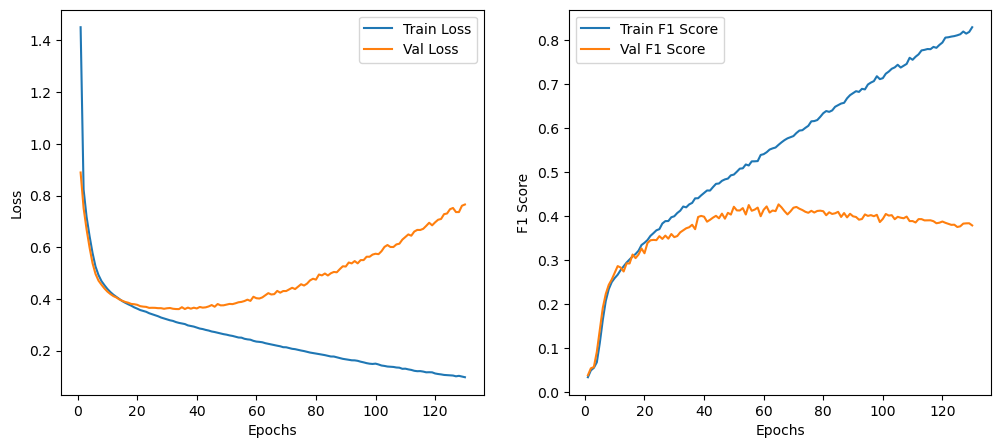

In [14]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()